In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, tzinfo
import pytz
from io import StringIO
import os
from IPython.display import Markdown
import boto3

In [3]:
# Wrapper function for convenience
def dm(text):
    return display(Markdown(text))

# Introduction
https://en.youbike.com.tw/region/main/stations/

In [4]:
class ConnectionToS3:
    """Factory method object to create an active boto3 S3 resource. Ensure the correct env variables are set before calling this object.

    Available class method:
        from_env(): create connection from environment variables

    """

    def __init__(
        self,
        bucket_name: str,
        aws_access_key_id: str,
        aws_secret_access_key: str,
        endpoint_url: str = None,
        region_name: str = "ap-northeast-1",
    ):
        self._resource = boto3.resource(
            "s3",
            endpoint_url=endpoint_url,
            region_name=region_name,
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key,
        )
        self._bucket_name = bucket_name

    @classmethod
    def from_env(cls):
        app_env = os.getenv("APP_ENV", "local")
        print("Loading from env: ", app_env)
        if app_env == "local":
            return cls(
                "local-youbike",
                os.environ["MINIO_ACCESS_KEY_ID"],
                os.environ["MINIO_SECRET_ACCESS_KEY"],
                f'http://{os.environ["MINIO_HOST"]}:9000'
            )
        elif app_env == "stage":
            return cls(
                "stage-youbike",
                os.environ["AWS_ACCESS_KEY_ID"],
                os.environ["AWS_SECRET_ACCESS_KEY"],
            )
        else:
            raise Exception(f"The argument env={app_env} is not valid.")

    @property
    def resource(self):
        return self._resource

    @property
    def bucket_name(self):
        return self._bucket_name



In [5]:
os.environ['APP_ENV'] = 'stage'

In [82]:
connection = ConnectionToS3.from_env()
connection.bucket_name

Loading from env:  stage


'stage-youbike'

In [9]:
def download_from_bucket(bucket_name: str, remote_path: str, filter: str, dest_dir: str):
    bucket = connection.resource.Bucket(bucket_name)

    for obj in bucket.objects.all():
        if f'{remote_path}{filter}' in obj.key:
            local_file_path = os.path.join(dest_dir, obj.key)
            if '/' in obj.key:
                os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
                connection.resource.meta.client.download_file(connection.bucket_name, obj.key, local_file_path)
            print(f"Downloaded {obj.key} at {dest_dir}")

In [11]:
def create_or_append_df(parquet_path: str, df: pd.DataFrame) -> pd.DataFrame:
    if df is None:
        concat_df = pd.read_parquet(parquet_path).loc[[]]
    else:
        df_to_append = pd.read_parquet(parquet_path)
        concat_df = pd.concat([df, df_to_append], join='outer')
    return concat_df

In [ ]:
download_from_bucket(connection.bucket_name, 'raw_data/', '', '../tmp_data/parquet_raw_data')

In [ ]:
#Create historical data df
hist_df = None
cnt = 0
for i in os.listdir('../tmp_data/parquet_raw_data/raw_data/'):
    if "youbike_dock_info_" in i:
        print(i)
        try: 
            hist_df = create_or_append_df(f"../tmp_data/parquet_raw_data/raw_data/{i}", hist_df)
        except:
            print("failed with ", i)
        cnt += 1
        print(f"Added: {cnt} / {len(os.listdir('../tmp_data/raw_data/'))}")

In [ ]:
#Enforce Schema for historical df
hist_df = hist_df[['id', 'name', 'type', 'space', 'full', 'empty', 'bike_yb2', 'bike_eyb', 'city', 'area',
         'lat', 'lng', 'address', 'is_open', 'place_id', 'last_update_ts', 'extraction_ts']].reset_index(drop=True)
display(hist_df.head(5), hist_df.shape)

In [22]:
#intermediary checkpoint
hist_df.to_parquet("./youbike_dock_info_history_2024-02-15_2024-03-13_raw.parquet", index=False)

In [ ]:
hist_df['last_update_ts'] = pd.to_datetime(hist_df['last_update_ts'], yearfirst=True)
hist_df['extraction_ts'] = pd.to_datetime(hist_df['extraction_ts'], yearfirst=True)

In [26]:
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10467683 entries, 0 to 10467682
Data columns (total 17 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   name            object 
 2   type            int64  
 3   space           int64  
 4   full            int64  
 5   empty           int64  
 6   bike_yb2        int64  
 7   bike_eyb        int64  
 8   city            object 
 9   area            object 
 10  lat             float64
 11  lng             float64
 12  address         object 
 13  is_open         int64  
 14  place_id        float64
 15  last_update_ts  object 
 16  extraction_ts   object 
dtypes: float64(3), int64(8), object(6)
memory usage: 1.3+ GB


# Validate & clean the dataset

In [31]:
# Analyze Raw da
main_df = pd.read_parquet("./youbike_dock_info_history_2024-02-15_2024-03-13_raw.parquet")



In [33]:
display(main_df.shape)
main_df.info()

(10467683, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10467683 entries, 0 to 10467682
Data columns (total 17 columns):
 #   Column          Dtype                                
---  ------          -----                                
 0   id              int64                                
 1   name            object                               
 2   type            int64                                
 3   space           int64                                
 4   full            int64                                
 5   empty           int64                                
 6   bike_yb2        int64                                
 7   bike_eyb        int64                                
 8   city            object                               
 9   area            object                               
 10  lat             float64                              
 11  lng             float64                              
 12  address         object                               


**Columns are understood as follows:**
- id: unique identifier per bike station
- type: youbike type (1.0, 2.0)
- space: total available bike slots per station (= full + empty)
- full: nbr of occupied slots (= bike_yb2 + bike_eyb)
- empty: nbr of available slots for parking
- bike_yb2: count of YouBike 2.0 in occupied slots (see 'full')
- bike_eyb: count of E-Youbike 2.0 in occupied slots (see 'full')
- city: city where bike station is located
- area: city's district where bike station is located
- lat: latitude coordinate of bike station
- lng: longitude coordinate of bike station
- place_id: ??
- address: postal address of bike station
- is_open: ??
- last_updated_ts: timestamp of data in unix epoch
- extraction_ts: ts data was pulled from API

## Check types & missing values

In [34]:
display(main_df.info(show_counts=True))
display(main_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10467683 entries, 0 to 10467682
Data columns (total 17 columns):
 #   Column          Non-Null Count     Dtype                                
---  ------          --------------     -----                                
 0   id              10467683 non-null  int64                                
 1   name            10467683 non-null  object                               
 2   type            10467683 non-null  int64                                
 3   space           10467683 non-null  int64                                
 4   full            10467683 non-null  int64                                
 5   empty           10467683 non-null  int64                                
 6   bike_yb2        10467683 non-null  int64                                
 7   bike_eyb        10467683 non-null  int64                                
 8   city            10303383 non-null  object                               
 9   area            104676

None

id                       0
name                     0
type                     0
space                    0
full                     0
empty                    0
bike_yb2                 0
bike_eyb                 0
city                164300
area                     0
lat                      0
lng                      0
address                  0
is_open                  0
place_id          10467683
last_update_ts           0
extraction_ts            0
dtype: int64

**Observation**
- place_id contains no value
- city has empty values
- updated_at is an int64

In [35]:
# Drop empty cities
main_df.drop(main_df[main_df["city"].isna()].index, inplace=True) # Discard vals with null cities

#Drop youbikes of type 1 - because soon discontinued
main_df.drop(main_df[main_df["type"] != 2].index, inplace=True)

# Convert ts - Not necessary since using parquet
# main_df["last_update_ts"] = pd.to_datetime(main_df["last_update_ts"], yearfirst=True) 
# main_df["extraction_ts"] = pd.to_datetime(main_df["extraction_ts"], yearfirst=True) 

## Discard irrelevant features

In [36]:
main_df.drop(labels=["name", "area", "address", 'place_id'], axis=1, inplace=True)

In [37]:
dm("#### Any missing values left?")
display(main_df.isna().sum())

#### Any missing values left?

id                0
type              0
space             0
full              0
empty             0
bike_yb2          0
bike_eyb          0
city              0
lat               0
lng               0
is_open           0
last_update_ts    0
extraction_ts     0
dtype: int64

## Check assumptions

In [38]:
# Space = full + empty

space_uneq = main_df[main_df["space"] != (main_df["full"] + main_df["empty"])]


display(Markdown('#### Checking if space = full + empty'))
display(Markdown(f'**Rows where unequal:** {space_uneq.shape[0]}'))
display(Markdown(f'**As proportion of total dataset:** {space_uneq.shape[0] / main_df.shape[0]}')) #displays ratio of total bikes 
display(Markdown('**Excerpt output**'))
display(space_uneq.head(5)) # Displays where it is not true
dm(f'**conclusion:** Understanding the is_open code mapping would be useful to assess how to handle these records')

#### Checking if space = full + empty

**Rows where unequal:** 954307

**As proportion of total dataset:** 0.1058002807350998

**Excerpt output**

,id,type,space,full,empty,bike_yb2,bike_eyb,city,lat,lng,is_open,last_update_ts,extraction_ts
3,500312002,2,21,0,0,0,0,桃園市,25.05246,121.29786,0,2024-02-22 10:34:19+08:00,2024-02-22 15:42:19+08:00
4,500301028,2,17,0,0,0,0,桃園市,24.92931,121.28456,0,2024-02-22 11:03:20+08:00,2024-02-22 15:42:19+08:00
15,501335005,2,22,0,0,0,0,臺南市,22.92332,120.28666,0,2024-02-20 15:14:18+08:00,2024-02-22 15:42:19+08:00
16,501335006,2,20,0,0,0,0,臺南市,22.92629,120.28519,0,2024-02-20 15:14:17+08:00,2024-02-22 15:42:19+08:00
17,501323028,2,14,0,0,0,0,臺南市,22.96601,120.18523,0,2024-02-20 15:16:17+08:00,2024-02-22 15:42:19+08:00


**conclusion:** Understanding the is_open code mapping would be useful to assess how to handle these records

In [39]:
dm(f'Inequality appears across all is_open, and mostly on 0 and 2. \n Proportion rows unequal vs total per is_open')
display(space_uneq["is_open"].value_counts() / main_df["is_open"].value_counts())

Inequality appears across all is_open, and mostly on 0 and 2. 
 Proportion rows unequal vs total per is_open

is_open
0    0.267788
1    0.096824
2    0.654579
3         NaN
4    0.036075
5    0.119177
Name: count, dtype: float64

In [40]:
dm('#### Check if full = bike_yb2 + bike_eyb')
full_uneq = main_df[main_df["full"] != (main_df["bike_yb2"] + main_df["bike_eyb"])]
dm(f'**Rows where unequal:** {full_uneq.shape[0]}')
dm(f'**Excerpt output where unequal**')
display(full_uneq.head(5))
dm(f'**Conclusion**: Assumption is valid')

#### Check if full = bike_yb2 + bike_eyb

**Rows where unequal:** 0

**Excerpt output where unequal**

,id,type,space,full,empty,bike_yb2,bike_eyb,city,lat,lng,is_open,last_update_ts,extraction_ts


**Conclusion**: Assumption is valid

## Check range and distribution of values

### Categorical

In [41]:
main_df_cat = main_df.select_dtypes(include=["category", "object"]) 
main_df_cat["type"] = hist_df["type"]
main_df_cat["is_open"] = hist_df["is_open"]

In [42]:
for col in main_df_cat.columns:
    unique_values = main_df[col].unique()
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'city': ['台北市' '桃園市' '臺南市' '高雄市' '新北市' '台中市' '新竹科學工業園區' '屏東縣' '嘉義市' '苗栗縣' '新竹縣'
 '新竹市']
Unique values in 'type': [2]
Unique values in 'is_open': [0 1 2 5 4 3]


In [43]:
#Map city to ascii chars
city_name_glossary = {"新北市": "XinBeiShi",
                      "台北市": "TaiBeiShi",
                      "台中市":"TaiZhongShi",
                      "高雄市":"KaoXiongShi",
                      "桃園市":"TaoYuanShi",
                      "臺南市": "TaiNanShi",
                      "嘉義市": "JiaYiShi",
                      "屏東縣": "PingDongXian",
                      "新竹市": "XinZhuShi",
                      "新竹縣": "XinZhuXian",
                      "苗栗縣" : "MiaoLiXian",
                      "新竹科學工業園區": "XinZhuKeXueGong"}  

#TODO Need to catch KeyError and set default value. 
main_df["city"] = main_df.apply(lambda x: city_name_glossary[x["city"]], axis=1)


### Numerical

In [44]:
main_df_num = main_df.drop(labels=main_df_cat.columns, axis=1)
main_df_num['last_update_ts'] = main_df['last_update_ts'].copy(deep=True)
main_df_num['extraction_ts'] = main_df['extraction_ts'].copy(deep=True)

In [45]:
pd.set_option('display.float_format', '{:.2f}'.format)


In [46]:
main_df_num.describe(include='all')

,id,space,full,empty,bike_yb2,bike_eyb,lat,lng,last_update_ts,extraction_ts
count,9019891.00,9019891.00,9019891.00,9019891.00,9019891.00,9019891.00,9019891.00,9019891.00,9019891,9019891
mean,500639565.85,20.89,6.98,13.44,6.68,0.31,24.11,120.56,2024-03-01 11:53:32.968970+08:00,2024-03-02 18:45:48.909483+08:00
min,500101001.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2024-01-14 01:18:15+08:00,2024-02-15 19:41:49+08:00
25%,500207018.00,14.00,2.00,7.00,2.00,0.00,23.01,120.38,2024-02-22 14:21:43+08:00,2024-02-23 09:46:26+08:00
50%,500602036.00,17.00,5.00,11.00,5.00,0.00,24.39,120.81,2024-03-01 22:45:18+08:00,2024-03-02 02:48:34+08:00
75%,501203107.00,24.00,9.00,17.00,9.00,0.00,25.03,121.49,2024-03-10 21:45:18+08:00,2024-03-11 02:30:54+08:00
max,508201041.00,99.00,99.00,99.00,99.00,62.00,25.29,122.00,2024-03-13 12:09:19+08:00,2024-03-13 12:10:56+08:00
std,742878.20,11.86,7.07,10.19,6.98,1.14,1.64,6.79,NaN,NaN


**Observations about range and distribution**
- Empty has negative values
- Space min value is zero
- Some long/lat coordinates are outside of Taiwan
- Some ts shows stale data (many days older than latest ts)
- Rest is according to expectations

In [47]:
dm("""
**Dropping:**
- Stations with negative empty values. (= Available spaces cannot be negative.)
- Stations without space are irrelevant
- Stations located outside of Taiwan (these are test locations. Confirmed by not being displayed on YouBikes official map)
- Stations with last_update_ts older than the first day of this historical dataset. (Stale data is useless)
""")
dm(f"Row counts before: {main_df.shape[0]}")
discard_mask = (
    (main_df["empty"] < 0)
    | (main_df["space"] < 1) # Stations without space are irrelevant
    | (main_df["lat"] < 21.89) #southermost lat of Taiwan's main island
    | (main_df["lng"] < 120) #westernmost lng of Taiwan's main island
    | (main_df["last_update_ts"] < pd.to_datetime("2024-02-16").tz_localize(tz='Asia/Taipei'))
)
main_df.drop(main_df[discard_mask == True].index, inplace=True)

dm(f"Row counts after: {main_df.shape[0]}")
#TODO: bound to the easter and northernmost points too? 


**Dropping:**
- Stations with negative empty values. (= Available spaces cannot be negative.)
- Stations without space are irrelevant
- Stations located outside of Taiwan (these are test locations. Confirmed by not being displayed on YouBikes official map)
- Stations with last_update_ts older than the first day of this historical dataset. (Stale data is useless)


Row counts before: 9019891

Row counts after: 8741784

## Check uniqueness of observations

In [48]:
dm("#### Unique key is (extraction_ts, id)") 

main_df['identical_key_cnt'] = main_df.groupby(['extraction_ts', 'id']).transform('size')
display(main_df['identical_key_cnt'].value_counts())
dm("key_cnt = 1 means no duplicates")

#### Unique key is (extraction_ts, id)

identical_key_cnt
1    8741784
Name: count, dtype: int64

key_cnt = 1 means no duplicates

In [49]:
dm("### Does each station have a unique record per extraction? (uniqueness on position (= Lat / Lng)")

main_df["pos"] = main_df.apply(lambda x: (x["lat"], x["lng"]), axis=1)
main_df["duplic_pos"] = main_df.groupby(['pos', 'extraction_ts']).transform('size')

display(main_df[main_df["duplic_pos"] > 1].head(4))
dm("**Observation:** Some Lat / Lng are recorded twice within the same extraction")
display(main_df["duplic_pos"].value_counts())
dm("<br>Filtering for those positions which are recorded twice returns ")
display(main_df[main_df["duplic_pos"] > 1]["pos"].value_counts())
dm("**Conclusion**: For the moment, any duplicated station (identified by using pos) per extraction will be dismissed")

### Does each station have a unique record per extraction? (uniqueness on position (= Lat / Lng)

,id,type,space,full,empty,bike_yb2,bike_eyb,city,lat,lng,is_open,last_update_ts,extraction_ts,identical_key_cnt,pos,duplic_pos
5462,500199002,2,17,3,13,3,0,TaiBeiShi,25.00,121.54,5,2024-02-22 15:37:18+08:00,2024-02-22 15:42:19+08:00,1,"(24.99609, 121.54284)",2
6404,500105068,2,10,0,10,0,0,TaiBeiShi,25.00,121.54,1,2024-02-22 15:12:14+08:00,2024-02-22 15:42:19+08:00,1,"(24.99609, 121.54284)",2
13400,500199002,2,17,0,17,0,0,TaiBeiShi,25.00,121.54,5,2024-03-07 18:19:20+08:00,2024-03-07 18:25:10+08:00,1,"(24.99609, 121.54284)",2
14342,500105068,2,10,1,9,1,0,TaiBeiShi,25.00,121.54,1,2024-03-07 18:23:14+08:00,2024-03-07 18:25:10+08:00,1,"(24.99609, 121.54284)",2


**Observation:** Some Lat / Lng are recorded twice within the same extraction

duplic_pos
1    8739140
2       2644
Name: count, dtype: int64

<br>Filtering for those positions which are recorded twice returns 

pos
(24.99609, 121.54284)    2644
Name: count, dtype: int64

**Conclusion**: For the moment, any duplicated station (identified by using pos) per extraction will be dismissed

In [50]:
dm("Dropping stations with duplicated pos, extraction_ts")
dm(f"Row count before: {main_df.shape[0]}")

main_df.drop(main_df[main_df["duplic_pos"] > 1].index, inplace=True)

dm(f"Row count after: {main_df.shape[0]}")

Dropping stations with duplicated pos, extraction_ts

Row count before: 8741784

Row count after: 8739140

In [53]:
#Last visual check before dl
#Checkpoint
base_df = main_df[['id', 'space', 'full', 'empty', 'bike_yb2', 'bike_eyb', 'city', 
                   'lat', 'lng', 'is_open', 'last_update_ts', 'extraction_ts']].copy(deep=True)
base_df

,id,space,full,empty,bike_yb2,bike_eyb,city,lat,lng,is_open,last_update_ts,extraction_ts
0,500109091,13,0,13,0,0,TaiBeiShi,25.14,121.50,0,2024-02-22 10:31:19+08:00,2024-02-22 15:42:19+08:00
2,500106124,15,0,15,0,0,TaiBeiShi,25.04,121.53,0,2024-02-22 14:56:19+08:00,2024-02-22 15:42:19+08:00
3,500312002,21,0,0,0,0,TaoYuanShi,25.05,121.30,0,2024-02-22 10:34:19+08:00,2024-02-22 15:42:19+08:00
4,500301028,17,0,0,0,0,TaoYuanShi,24.93,121.28,0,2024-02-22 11:03:20+08:00,2024-02-22 15:42:19+08:00
6,501217009,10,3,7,3,0,KaoXiongShi,22.91,120.19,1,2024-02-22 14:25:15+08:00,2024-02-22 15:42:19+08:00
...,...,...,...,...,...,...,...,...,...,...,...,...
10466648,500101012,8,8,0,8,0,TaiBeiShi,25.02,121.53,1,2024-03-03 13:51:20+08:00,2024-03-03 13:54:19+08:00
10466649,500101013,9,8,1,8,0,TaiBeiShi,25.03,121.54,1,2024-03-03 13:50:24+08:00,2024-03-03 13:54:19+08:00
10466650,500101014,11,10,1,10,0,TaiBeiShi,25.02,121.53,1,2024-03-03 13:52:19+08:00,2024-03-03 13:54:19+08:00
10466651,500101015,14,14,0,14,0,TaiBeiShi,25.02,121.55,1,2024-03-03 13:52:18+08:00,2024-03-03 13:54:19+08:00


In [55]:
base_df.to_parquet("../tmp_data/clean_data/youbike_dock_info_history_2024-02-22_2024-03-13.parquet", index=False)

# Analyze Data


In [77]:
rand_id = base_df['id'].sample(1, ignore_index=True)[0]
print(rand_id)

500604028


In [78]:
eg_id = rand_id
# base_df.sort_values(by=["id", "last_update_ts"]).head(50)
s_1 = base_df[base_df["id"] == eg_id] \
    .sort_values(by=["id", "extraction_ts"], ascending=False) \
    .copy(deep=True).reset_index(drop=True)
# s_1.drop_duplicates(subset="last_update_ts", inplace=True)
s_1["pct_full"] = s_1["full"] / s_1["space"]

## Apply rolling average 

s_1["30m_rol_avg_pct_full"] = s_1['pct_full'].rolling(window=3).mean() #Assumes each record is 10 mins

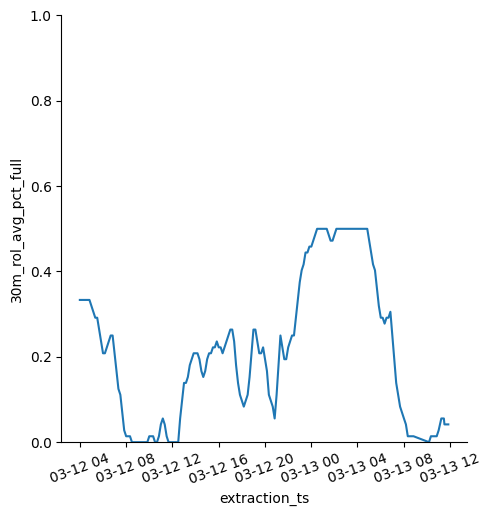

In [80]:
sns.relplot(data=s_1.iloc[:188], kind="line", x="extraction_ts", y="30m_rol_avg_pct_full")

plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.show()

In [81]:
s_1.head(10)

,id,space,full,empty,bike_yb2,bike_eyb,city,lat,lng,is_open,last_update_ts,extraction_ts,pct_full,30m_rol_avg_pct_full
0,500604028,24,1,23,0,1,TaiZhongShi,24.13,120.68,1,2024-03-13 11:44:20+08:00,2024-03-13 12:10:56+08:00,0.04,NaN
1,500604028,24,1,23,0,1,TaiZhongShi,24.13,120.68,1,2024-03-13 11:44:20+08:00,2024-03-13 12:01:04+08:00,0.04,NaN
2,500604028,24,1,23,0,1,TaiZhongShi,24.13,120.68,1,2024-03-13 11:44:20+08:00,2024-03-13 11:51:00+08:00,0.04,0.04
3,500604028,24,1,23,0,1,TaiZhongShi,24.13,120.68,1,2024-03-13 11:28:18+08:00,2024-03-13 11:40:55+08:00,0.04,0.04
4,500604028,24,1,23,0,1,TaiZhongShi,24.13,120.68,1,2024-03-13 11:28:18+08:00,2024-03-13 11:30:56+08:00,0.04,0.04
5,500604028,24,2,22,1,1,TaiZhongShi,24.13,120.68,1,2024-03-13 11:22:19+08:00,2024-03-13 11:28:02+08:00,0.08,0.06
6,500604028,24,1,23,1,0,TaiZhongShi,24.13,120.68,1,2024-03-13 11:12:14+08:00,2024-03-13 11:20:46+08:00,0.04,0.06
7,500604028,24,1,23,1,0,TaiZhongShi,24.13,120.68,1,2024-03-13 11:12:14+08:00,2024-03-13 11:14:44+08:00,0.04,0.06
8,500604028,24,0,24,0,0,TaiZhongShi,24.13,120.68,1,2024-03-13 10:49:14+08:00,2024-03-13 11:00:54+08:00,0.00,0.03
9,500604028,24,0,24,0,0,TaiZhongShi,24.13,120.68,1,2024-03-13 10:49:14+08:00,2024-03-13 10:50:51+08:00,0.00,0.01
